In [352]:
%pip install nfl_data_py
%pip install fuzzywuzzy
%pip install python-Levenshtein
%pip install networkx
%pip install wordcloud
%pip install seaborn
%pip install mplcursors
%pip install altair vega_datasets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [353]:
import nfl_data_py as nfl
import altair as alt

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
from wordcloud import WordCloud

from fuzzywuzzy import process
from matplotlib.ticker import FuncFormatter

In [354]:
# Load play-by-play data for 2024 season
df = nfl.import_pbp_data([2024])

# Load seasonal rosters for 2024 season
roster_data = nfl.import_seasonal_rosters([2024])

# Load weekly rosters for 2024 season
weekly_rosters = nfl.import_weekly_rosters([2024])

# Show first 5 rows
print(df.head())
print(roster_data.head())

2024 done.
Downcasting floats.
   play_id          game_id old_game_id home_team away_team season_type  week  \
0      1.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
1     40.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
2     61.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
3     83.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
4    108.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   

  posteam posteam_type defteam  ... out_of_bounds  home_opening_kickoff  \
0    None         None    None  ...           0.0                   0.0   
1     ARI         away     BUF  ...           0.0                   0.0   
2     ARI         away     BUF  ...           0.0                   0.0   
3     ARI         away     BUF  ...           0.0                   0.0   
4     ARI         away     BUF  ...           0.0                   0.0   

     qb_epa  xyac_epa  xyac_mea

# Merging the data

We will be merging salary data from overthecap.com with our nfl roster_data based on fuzzy matching the player names and teams from both data sources.

We are using fuzzy matching to connect the salary data with nfl_data_py's roster data using both the player name fields and the team fields. To do this, we are mapping the 3 letter abbreviation to the team in salary data and concatenating it with the player name. That way, fuzzy matching matches BOTH the name and team. We have to do this because a couple players appear on different teams for the same year (2024).

With salary data matched onto nfl_data_py's roster data, we can now join the roster data with the play by play data by the player id column. This now allows us to associate dollar values to first down plays.

In [356]:
# Fuzzy match helper function
def get_best_match(player, choices, threshold=85):
    match, score = process.extractOne(player, choices)
    return match if score >= threshold else None


In [357]:

df_salary = pd.read_csv('overthecap/overthecap-earnings.csv')
df_salary = df_salary[df_salary['year'] == 2024]

# Team mapping for NFL teams to their abbreviations for identifier creation
team_map = {
    'Vikings': 'MIN',
    'Packers': 'GB',
    'Bears': 'CHI',
    'Lions': 'DET',
    'Texans': 'HOU',
    'Titans': 'TEN',
    'Colts': 'IND',
    'Jaguars': 'JAX',
    'Ravens': 'BAL',
    'Steelers': 'PIT',
    'Bengals': 'CIN',
    'Browns': 'CLE',
    'Cowboys': 'DAL',
    'Giants': 'NYG',
    'Eagles': 'PHI',
    'Commanders': 'WAS',
    'Falcons': 'ATL',
    'Panthers': 'CAR',
    'Saints': 'NO',
    'Buccaneers': 'TB',
    'Cardinals': 'ARI',
    'Rams': 'LAR',
    '49ers': 'SF',
    'Seahawks': 'SEA',
    'Bills': 'BUF',
    'Dolphins': 'MIA',
    'Patriots': 'NE',
    'Jets': 'NYJ',
    'Chargers': 'LAC',
    'Raiders': 'LV',
    'Chiefs': 'KC',
    'Broncos': 'DEN',
    'Panthers': 'CAR',
}

df_salary['identifier'] = df_salary['player_name'] + '-' + df_salary['team'].map(team_map)

df_salary

,player_name,year,team,base_salary,prorated_bonus,Unnamed: 5,guaranteed_salary,capnumber,cap_percent,cash_paid,identifier
0,Michael Dickson,2024,Seahawks,2550000,1300000.0,NaN,0.0,3850000,1.5%,2550000,Michael Dickson-SEA
1,Rigoberto Sanchez,2024,Colts,1250000,0.0,NaN,2500000.0,2500000,1.0%,2500000,Rigoberto Sanchez-IND
2,Cameron Johnston,2024,Steelers,1125000,958333.0,NaN,0.0,2083333,0.8%,4000000,Cameron Johnston-PIT
3,Bradley Pinion,2024,Falcons,2245000,500000.0,NaN,1080000.0,3000000,1.2%,2500000,Bradley Pinion-ATL
4,Bryan Anger,2024,Cowboys,3000000,800000.0,NaN,0.0,3800000,1.5%,3000000,Bryan Anger-DAL
...,...,...,...,...,...,...,...,...,...,...,...
2576,Corey Bojorquez,2024,Browns,1125000,437500.0,NaN,1125000.0,1562500,0.5%,2000000,Corey Bojorquez-CLE
2577,Jamie Gillan,2024,Giants,1630000,500000.0,NaN,250000.0,2400000,0.9%,1900000,Jamie Gillan-NYG
2578,Tommy Townsend,2024,Texans,1125000,1000000.0,NaN,0.0,2225000,0.9%,3225000,Tommy Townsend-HOU
2579,Riley Dixon,2024,Broncos,1735000,300000.0,NaN,0.0,2035000,0.8%,1735000,Riley Dixon-DEN


In [451]:
def get_best_match_identifiers(x):
    identifiers = df_salary['identifier'].unique().tolist()
    return get_best_match(x, identifiers)

In [452]:
# Create identifier, handling NaN values in team column
roster_data['team'] = roster_data['team'].dropna()
roster_data['identifier'] = roster_data['player_name'] + '-' + roster_data['team']


# Fuzzy match each player with identifiers
roster_data['matched_identifier'] = roster_data['identifier'].apply(
    get_best_match_identifiers
)

# Merge on matched identifiers
player_salary_df = pd.merge(
    roster_data,
    df_salary,
    left_on='matched_identifier',
    right_on='identifier',
    how='left'
)

# Drop players with no salary info
player_salary_df = player_salary_df.dropna(subset=['base_salary'])


# Cleaning the Play-by-Play Data

We only take the data where the first down is successful, i.e. where the first_down column equals 1. Options for the first_down column are 1 for successes, 0 for failures, and N/A.

In [453]:
# Filter for plays where a first down was achieved
first_down_plays = df[df['first_down'] == 1]

total_plays = len(df)

# Total number of first downs
total_first_downs = len(first_down_plays)

print("Total plays:", total_plays)
print("Total first downs:", int(total_first_downs))

Total plays: 49492
Total first downs: 11148


# How much does each team pay for their first downs?

Now we will examine first down conversions by team. To do this we will use the "posteam" column that indicates which team had possession of the ball (i.e. the team on offense). We will also see how much each team pays for its active offense players.

Since there is no column in the play-by-play data or the roster data on who was actually on the field at any given time, we made an assumption that any active player was expected to play for that team and contribute to a first down.

We can find active players by using the status column in the weekly roster data, which says whether they were active, on reserve, or cut from the team for a certain week. We filtered the weekly roster data by keeping players who were active at any point during the season and dropping duplicate names on the same team. That way, we have a roster of all active players for the 2024 season.

If a person were to have played for multiple teams, they will contribute to the total salary of both teams.

In [ ]:
# Group by team on offense and count first downs
first_downs_by_team = first_down_plays.groupby('posteam')['first_down'].count()

# Sort and display
first_downs_by_team = first_downs_by_team.sort_values(ascending=False)

print(first_downs_by_team.head())

posteam
WAS    447
PHI    440
BAL    438
DET    433
BUF    423
Name: first_down, dtype: int64


In [ ]:
# Now we will get the active offensive players from the weekly rosters
active_roster_data = weekly_rosters[weekly_rosters['status'] == 'ACT']

offensive_positions = [
    'QB', 'RB', 'WR', 'TE', 'OL'
]

# Filter roster data for offensive positions
active_offensive_players = active_roster_data[
    active_roster_data['position'].isin(offensive_positions)
]

# Get only unique player names
active_offensive_players = active_offensive_players[
    ['player_name', 'team', 'position', 'player_id']
].drop_duplicates()

# Merge active offensive players with salary data on player_id
active_offensive_players = pd.merge(
    active_offensive_players,
    player_salary_df[['player_name_x', 'base_salary', 'player_id']],
    on= 'player_id',
    how='left'
)

active_offensive_players = active_offensive_players.dropna(subset=['base_salary'])

# We may be using this dataframe later, so let's keep this for later use
active_offensive_players

,player_name,team,position,player_id,player_name_x,base_salary
0,Aaron Rodgers,NYJ,QB,00-0023459,Aaron Rodgers,3161112.0
1,Marcedes Lewis,CHI,TE,00-0024243,Marcedes Lewis,1600000.0
2,Joe Flacco,IND,QB,00-0026158,Joe Flacco,3000000.0
3,Josh Johnson,BAL,QB,00-0026300,Josh Johnson,1210000.0
4,Matthew Stafford,LA,QB,00-0026498,Matthew Stafford,23500000.0
...,...,...,...,...,...,...
1062,Rome Odunze,CHI,WR,00-0039919,Rome Odunze,795000.0
1063,Malachi Corley,NYJ,WR,00-0039920,Malachi Corley,795000.0
1064,Trey Benson,ARI,RB,00-0039921,Trey Benson,795000.0
1065,Amarius Mims,CIN,OL,00-0039925,Amarius Mims,795000.0


In [402]:
# Then we will get the total base salaries for each team
team_list = active_offensive_players['team'].unique().tolist()

team_total_salaries = []

for team in team_list:
    team_data = active_offensive_players[active_offensive_players['team'] == team]
    total_salary = team_data['base_salary'].sum()
    team_total_salaries.append({
        'team': team,
        'total_salary': total_salary
    })

team_salary_df = pd.DataFrame(team_total_salaries).sort_values(by='total_salary', ascending=False)

team_salary_df.head()

,team,total_salary
4,LA,96573859.0
2,IND,91935448.0
16,KC,79814507.0
8,ARI,75890199.0
30,CIN,73335782.0


In [403]:
# Join first downs by team with total salaries
team_first_downs = first_downs_by_team.reset_index().copy()
team_first_downs.columns = ['team', 'first_downs']
team_first_downs_with_salary = pd.merge(
    team_first_downs,
    team_salary_df,
    on='team',
    how='left'
)

team_first_downs_with_salary = team_first_downs_with_salary.sort_values(by='first_downs', ascending=False)

team_first_downs_with_salary.head()

,team,first_downs,total_salary
0,WAS,447,52659609.0
1,PHI,440,33236964.0
2,BAL,438,54210078.0
3,DET,433,40237410.0
4,BUF,423,30375680.0


In [404]:
average_team_salary = team_first_downs_with_salary['total_salary'].mean()
print(f"Average team salary: ${average_team_salary / 1_000_000:.3f} million")

Average team salary: $53.308 million


In [405]:
team_first_downs_with_salary['salary_per_first_down'] = team_first_downs_with_salary['total_salary'] / team_first_downs_with_salary['first_downs']
# Display the final DataFrame

team_first_downs_with_salary = team_first_downs_with_salary.sort_values(by='salary_per_first_down', ascending=True)

team_first_downs_with_salary.head()

,team,first_downs,total_salary,salary_per_first_down
4,BUF,423,30375680.0,71810.118203
1,PHI,440,33236964.0,75538.554545
3,DET,433,40237410.0,92927.043880
12,GB,354,34193592.0,96592.067797
13,SF,349,36838300.0,105553.868195


In [406]:
average_team_salary_per_first_down = team_first_downs_with_salary['salary_per_first_down'].mean()
print(f"Average team salary per first down: ${average_team_salary_per_first_down:.2f}")

Average team salary per first down: $155877.99


In [407]:
def format_salary(value):
    #Format salary in dollars with commas
    return f"${value:,.0f}"

# Extra declaration for use in double y-axis charts
def format_salary_double_axis(value, _):
    return format_salary(value)


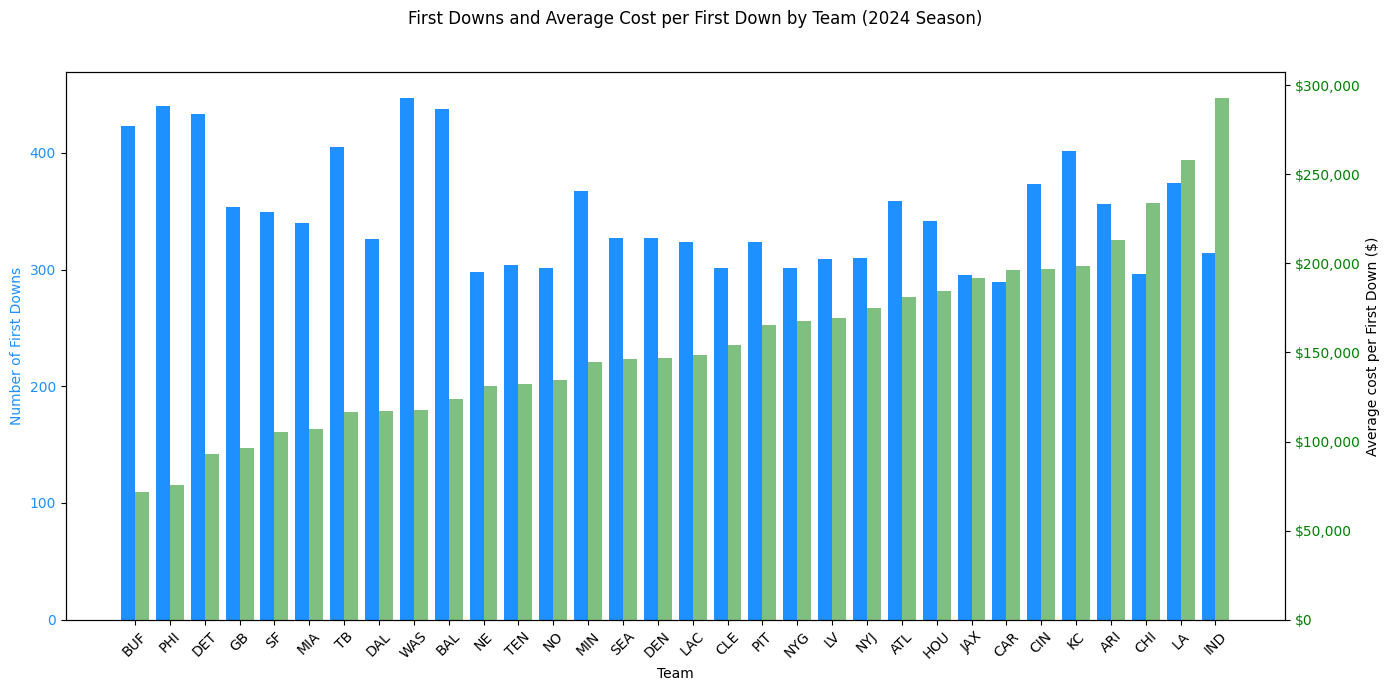

In [411]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Set bar width and positions
bar_width = 0.4
x = np.arange(len(team_first_downs_with_salary))

# Bars for first downs (left y-axis)
ax1.bar(x - bar_width/2, team_first_downs_with_salary['first_downs'], 
    width=bar_width, color='dodgerblue', label='First Downs')
ax1.set_xlabel('Team')
ax1.set_ylabel('Number of First Downs', color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')
ax1.set_xticks(x)
ax1.set_xticklabels(team_first_downs_with_salary['team'], rotation=45)

# Bars for total salary (right y-axis)
ax2 = ax1.twinx()
ax2.bar(x + bar_width/2, team_first_downs_with_salary['salary_per_first_down'], 
    width=bar_width, color='green', alpha=0.5, label='Total Salary per First Down')
ax2.set_ylabel('Average cost per First Down ($)',)
ax2.tick_params(axis='y', labelcolor='green')
formatter = FuncFormatter(format_salary_double_axis)
ax2.yaxis.set_major_formatter(formatter)

ax2.tick_params(axis='y')

# Legends and title
fig.suptitle('First Downs and Average Cost per First Down by Team (2024 Season)')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The Buffalo Bills pay an average of ~$100k per first down.  This was calculated by taking the Bills' roster's total salary and dividing it by the number of first downs the Bills were able to convert. This is way below the NFL average of ~$150k per first down. This makes the Bills the most cost-efficient team, right alongside the Philadelphia Eagles, the winners of last year's Super Bowl.

The Indianapolis Colts, the LA Rams, and the Chicago Bears pay the most total team salary per first down. 

In [409]:
total_salary = team_first_downs_with_salary['total_salary'].sum()

num_teams = len(team_first_downs_with_salary)

average_team_salary = total_salary / num_teams

average_salary_per_first_down = total_salary / total_first_downs if total_first_downs > 0 else 0

print(f"Total Salary for all teams: ${total_salary/1000_000:,.2f}M")
print(f"Average Total Salary per Team: ${average_team_salary/1000_000:,.2f}M")
print(f"Average Cost per First Down: ${average_salary_per_first_down:,.2f}")



Total Salary for all teams: $1,705.87M
Average Total Salary per Team: $53.31M
Average Cost per First Down: $153,019.86


# Visualizing where the most first down conversions occur and fail

We will now visualize where first downs occur on the field with a heat map. We will sort plays into bins representing a 5 yard section of the field. Bins with a darker hue indicate more first down conversions occurring in that section of the field. 

By multiplying each first down count by the average cost per first down, we can see how much each section of the field costs the league.

We will use this visualization to see if money is spent evenly across the field or whether it can be spent strategically in key areas.

We're looking at this at the NFL level as a whole regardless as team.

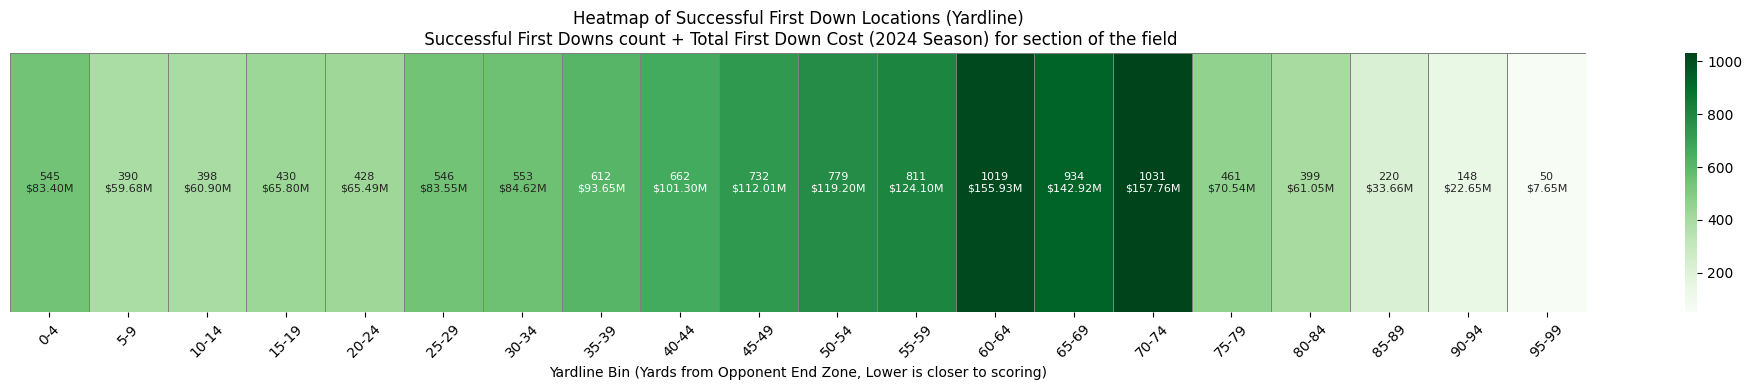

In [412]:
first_down_plays_binned = first_down_plays.copy()

# Create bins for yardline_100, e.g., every 5 yards
first_down_plays_binned['yard_bin'] = pd.cut(first_down_plays_binned['yardline_100'], bins=range(0, 105, 5), right=False)

# Count first downs per bin
yard_counts = first_down_plays_binned.groupby('yard_bin').size().reset_index(name='count')

# Total cost per first down for each yard bin
yard_counts['total_cost_per_first_down'] = (
    average_salary_per_first_down * yard_counts['count'].replace(0, np.nan)
)

# Create annotations for the heatmap with average cost per yard bin
annotations = []
for i, row in yard_counts.iterrows():
    cost = row['total_cost_per_first_down']
    if pd.isna(cost):
        cost_str = "N/A"
    elif cost >= 1000000:
        cost_str = f"${cost/1000000:.2f}M"
    elif cost >= 1000:
        cost_str = f"${cost/1000:.0f}k"
    else:
        cost_str = f"${cost:.0f}"
    annotations.append(f"{row['count']}\n{cost_str}")

# Create the heatmap with custom annotations
plt.figure(figsize=(20, 4))
sns.heatmap([yard_counts['count']], cmap='Greens', cbar=True, linewidths=0.5, linecolor='gray', 
            annot=[annotations], fmt='', annot_kws={'fontsize': 8})

plt.title('Heatmap of Successful First Down Locations (Yardline)\n Successful First Downs count + Total First Down Cost (2024 Season) for section of the field')
plt.yticks([], [])  # Hide y-axis ticks since it's just one row
plt.xticks(ticks=[
    i + 0.5 for i in range(len(yard_counts))], 
    labels=[f"{int(interval.left)}-{int(interval.right-1)}" for interval in yard_counts['yard_bin']], 
    rotation=45
)
plt.xlabel('Yardline Bin (Yards from Opponent End Zone, Lower is closer to scoring)')

plt.tight_layout()
plt.show()

**This heatmap should be read from right to left. Lower yards means closer to the opponents end zone, which is closer to scoring.**

It looks like the most first down conversions happen at the 60-74 yardlines.

The least happen at both extremes. The lowest values are at 95-99 yards with low values are at 5-24 yards.

For the league as a whole, this shows that the most expensive areas are the 60-74 yard area. The least expensive areas are the 90-99 yard section of the field.

To understand whether this is meaningful, we need to see if the first down count is a result of general gameplay or skewed data due to number of plays in that bin.

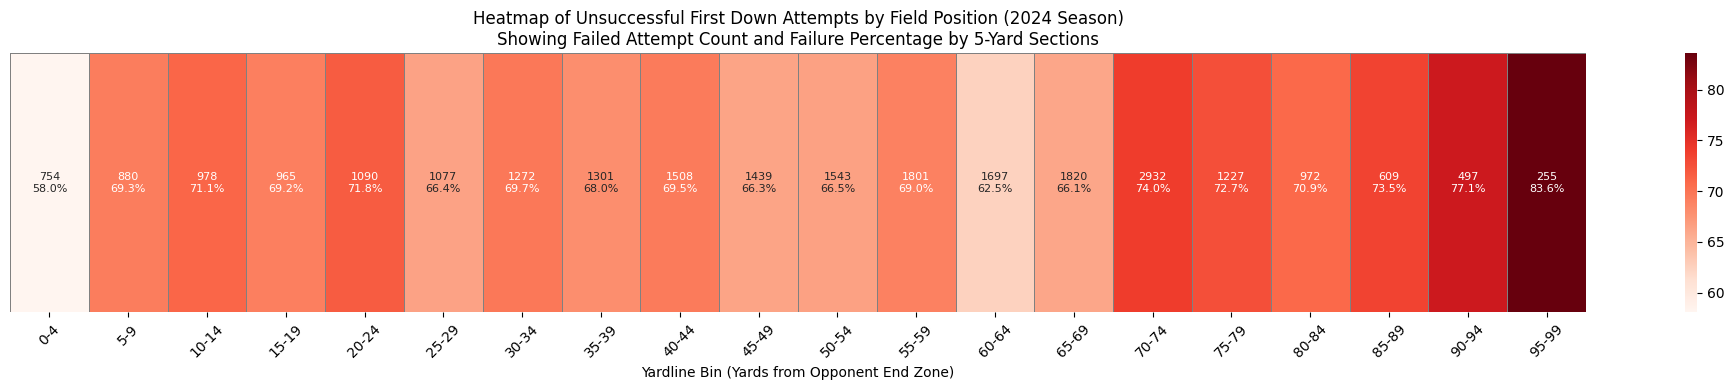

In [371]:
pass_run_plays = df[df['play_type'].isin(['pass', 'run'])]

failed_first_down_plays = pass_run_plays[pass_run_plays['first_down'] != 1].copy()

# Create bins for yardline_100, e.g., every 5 yards
failed_first_down_plays['yard_bin'] = pd.cut(failed_first_down_plays['yardline_100'], bins=range(0, 105, 5), right=False)

# Count failed first down attempts per bin
failed_yard_counts = failed_first_down_plays.groupby('yard_bin').size().reset_index(name='count')
failed_yard_counts = failed_yard_counts.merge(yard_counts[['yard_bin', 'count']], on='yard_bin', how='left', suffixes=('', '_successful'))

# Calculate the percentage of failed attempts in each bin
failed_yard_counts['percentage_failed'] = (
    failed_yard_counts['count'] / (failed_yard_counts['count'] + failed_yard_counts['count_successful'])
) * 100

# Create annotations for failed conversions with percentage
failed_annotations = []
for i, row in failed_yard_counts.iterrows():
    percentage = row['percentage_failed']
    if pd.isna(percentage):
        percentage_str = "N/A"
    else:
        percentage_str = f"{percentage:.1f}%"
    failed_annotations.append(f"{row['count']}\n{percentage_str}")

plt.figure(figsize=(20, 4))
sns.heatmap([failed_yard_counts['percentage_failed']], cmap='Reds', cbar=True, linewidths=0.5, linecolor='gray', 
            annot=[failed_annotations], fmt='', annot_kws={'fontsize': 8})

plt.title('Heatmap of Unsuccessful First Down Attempts by Field Position (2024 Season)\nShowing Failed Attempt Count and Failure Percentage by 5-Yard Sections')
plt.yticks([], [])  # Hide y-axis ticks since it's just one row
plt.xticks(ticks=[
    i + 0.5 for i in range(len(failed_yard_counts))], 
    labels=[f"{int(interval.left)}-{int(interval.right-1)}" for interval in failed_yard_counts['yard_bin']], 
    rotation=45
)
plt.xlabel('Yardline Bin (Yards from Opponent End Zone)')

plt.tight_layout()
plt.show()

The most first down failures happen at the 70-74 yard lines. Also the least first down failures happen at the 0-4 yard lines and 90-100 yard lines

First Down Efficiency seems relatively even across the whole board, with the rate of first down failures hovering between 60%-70%. There are outliers at the 90-100 and 0-4 yard range due to the low numbers.

This means the most plays happen at around the 70 yard line. The least number of plays happen at either extreme, at the 0-4 and 95-99 yard lines.

Since failure rate is pretty consistent throughout the field and the data indicates that more football in that 60-74 yard area, location doesn't seem to matter in obtaining first downs and thereby scoring.


Since we determined location on the field isn't the best way to gauge first down cost efficiency, let's break down first down conversions another way. Let's look at the kinds of plays that convert into first downs. The play-by-play data doesn't have any formation data. We only have a column that says whether a play was a running or passing play. We'll now see which of those two options have resulted in more first downs. 

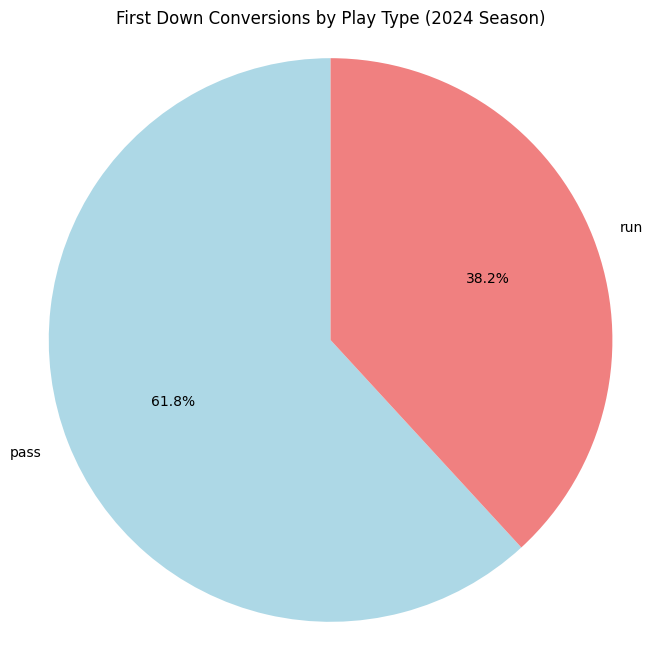

Pass plays resulting in first downs: 6,451
Run plays resulting in first downs: 3,982
Total first downs (pass + run): 10,433


In [372]:
# Filter first down plays for pass and run plays only
first_down_pass_run = first_down_plays[first_down_plays['play_type'].isin(['pass', 'run'])]

# Count the play types
play_type_counts = first_down_pass_run['play_type'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
colors = ['lightblue', 'lightcoral']
plt.pie(play_type_counts.values, labels=play_type_counts.index, autopct='%1.1f%%', 
    colors=colors, startangle=90)
plt.title('First Down Conversions by Play Type (2024 Season)')
plt.axis('equal')
plt.show()

# Print the counts
print(f"Pass plays resulting in first downs: {play_type_counts['pass']:,}")
print(f"Run plays resulting in first downs: {play_type_counts['run']:,}")
print(f"Total first downs (pass + run): {play_type_counts.sum():,}")

Splitting successful first down conversions by passing or running plays shows that a majority of first downs were achieved by passing across the whole league in 2024. This data suggests that money is more effectively spent on quarterbacks, wide receivers, and tight ends, who are instrumental to those more common plays. If there were more running plays that passing plays, then the data would suggest that money is more effectively spent on running backs.

# Player/Position Efficiency

We'll now see which players were in most first downs plays in 2024. There's no single column with all 22 players in a formation so we'll include players in strategic positions (such as quarterback, wide receiver, tight-end, running back) who have been named in the play by play data. We used the columns passer_player_id, receiver_player_id, and rusher_player_id to find these key players.

In [ ]:
def get_team_salaries(roster_data):
    # Filter out rows where salary is NaN
    roster_data = roster_data[roster_data['salary'].notna()]
    
    # Group by team and sum the salaries
    team_salaries = roster_data.groupby('team')['salary'].sum().reset_index()
    
    return team_salaries

In [374]:
def get_player_info(player_id, column_name):
    player_row = roster_data[roster_data['player_id'] == player_id]
    if not player_row.empty:
        return player_row[column_name].values[0]
    else:
        return 'Unknown Player'
    
def get_player_name(player_id):
    return get_player_info(player_id, 'player_name')

def get_player_position(player_id):
    return get_player_info(player_id, 'position')

# Define possible player columns for first down plays
possible_player_cols = [
    'passer_player_id',
    'rusher_player_id',
    'receiver_player_id'
]

# Make sure we only use existing columns
existing_player_cols = [
    col for col in possible_player_cols if col in first_down_plays.columns
    ]

# Collect all player info using the id columns
player_info = []

for id_col in existing_player_cols:
    temp_df = first_down_plays[[id_col, 'posteam']].dropna()
    temp_df["player_name"] = temp_df[id_col].apply(get_player_name)
    temp_df["player_position"] = temp_df[id_col].apply(get_player_position)
    temp_df["player_id"] = temp_df[id_col]
    
    player_info.append(temp_df)

# Combine all information DataFrames into one DataFrame
all_player_info_df = pd.concat(player_info)

# Filter columns to only relevant columns: player name and team
all_player_teams = all_player_info_df[['player_name', 'posteam', 'player_id']]
all_player_teams.columns = ['Player', 'Team', 'player_id']

# # Count occurrences of each player-team pair
player_team_counts = all_player_teams.value_counts().reset_index()
player_team_counts.columns = ['Player', 'Team', 'player_id', 'First_Down_Count']

# Sort and show top results
player_team_counts = player_team_counts.sort_values(
    by='First_Down_Count', ascending=False
    ).reset_index(drop=True)

# Show top 20
player_team_counts.head(20)

,Player,Team,player_id,First_Down_Count
0,Jayden Daniels,WAS,00-0039910,281
1,Patrick Mahomes,KC,00-0033873,278
2,Lamar Jackson,BAL,00-0034796,277
3,Joe Burrow,CIN,00-0036442,270
4,Josh Allen,BUF,00-0034857,268
5,Jared Goff,DET,00-0033106,266
6,Baker Mayfield,TB,00-0034855,263
7,Jalen Hurts,PHI,00-0036389,257
8,Sam Darnold,MIN,00-0034869,248
9,C.J. Stroud,HOU,00-0039163,232


We can visualize first down participations with a word cloud. Bigger names having contributed to more first downs. According to this table, Jayden Daniels, Patrick Mahomes, and Lamar Jackson should be the biggest names in the cloud. This visualization gives us a rough idea of the strongest players in the league since there are literally over 2500 active players.

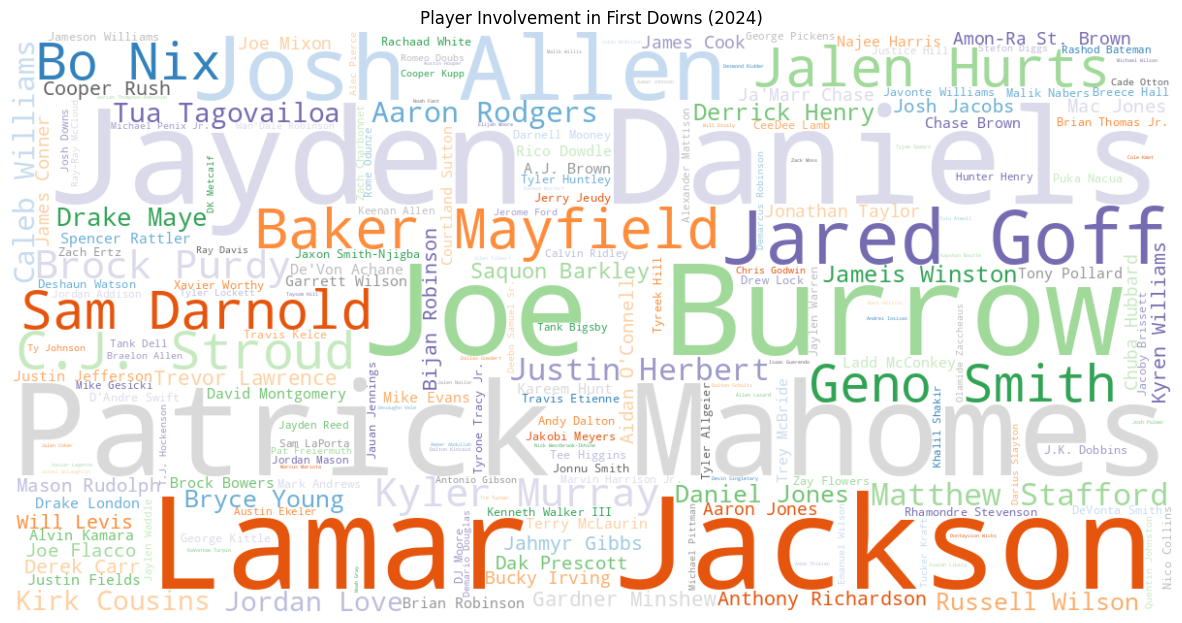

In [375]:
# Create the word cloud
player_counts = player_team_counts.set_index('Player')['First_Down_Count'].to_dict()

wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='tab20c').generate_from_frequencies(player_counts)

# Plot the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Player Involvement in First Downs (2024)')
plt.show()

Now that we know all the players we'll see which ones are most efficient cost-wise. We will divide their base salary by the number of successful first downs associated with them to get their cost-efficiency.

In [376]:
merged_df = pd.merge(
    player_team_counts,
    active_offensive_players[['player_name', 'position', 'team', 'base_salary', 'player_id']],
    left_on='player_id',
    right_on='player_id',
    how='left'
)
merged_df = merged_df.dropna(subset=['base_salary'])


With each player matched to their base salary, we can then sort them by their individual salary per first down they participated in.

In [377]:
# Convert base_salary to numeric, handling any potential issues with conversion
merged_df['base_salary'] = merged_df['base_salary'].astype(float)

# Compute salary per first down
merged_df['salary_per_first_down'] = merged_df['base_salary'] / merged_df['First_Down_Count']

# Clean final output
final_df = merged_df[['Player', 'team', 'position',  'First_Down_Count', 'base_salary', 'salary_per_first_down']]

# Remove duplicates: if player matched multiple teams, keep the one with most first downs
final_df = final_df.sort_values(['Player', 'First_Down_Count'], ascending=[True, False]).drop_duplicates('Player')

# Sort by salary efficiency
final_df = final_df.sort_values('salary_per_first_down', ascending=True)

display_df = final_df.copy()

# Format salary columns
display_df['base_salary'] = display_df['base_salary'].apply(format_salary)
display_df['salary_per_first_down'] = display_df['salary_per_first_down'].apply(format_salary)

# Rename columns for clarity
display_df.columns = ['Player',  'Team', 'Position', 'First Downs', 'Base Salary', 'Salary per First Down']

# Display
display_df.head(10)

,Player,Team,Position,First Downs,Base Salary,Salary per First Down
0,Jayden Daniels,WAS,QB,281,"$795,000","$2,829"
11,Bo Nix,DEN,QB,225,"$795,000","$3,533"
9,C.J. Stroud,HOU,QB,232,"$915,000","$3,944"
17,Caleb Williams,CHI,QB,200,"$795,000","$3,975"
4,Josh Allen,BUF,QB,268,"$1,125,000","$4,198"
6,Baker Mayfield,TB,QB,263,"$1,125,000","$4,278"
7,Jalen Hurts,PHI,QB,257,"$1,125,000","$4,377"
13,Brock Purdy,SF,QB,214,"$985,000","$4,603"
21,Drake Maye,NE,QB,138,"$795,000","$5,761"
19,Tua Tagovailoa,MIA,QB,169,"$1,125,000","$6,657"


As it turns out, this ended up being a list mainly of quarterbacks. Let's visualize each player's position and salary per first down in a scatter plot with different colors indicating positions

In [413]:
# Create Altair scatter plot with base salary vs first downs colored by position
player_scatter = alt.Chart(final_df).mark_circle(size=100, opacity=0.7).encode(
    x=alt.X('First_Down_Count:Q', title='First Down Count'),
    y=alt.Y('base_salary:Q', title='Base Salary ($)', 
            axis=alt.Axis(format='$,.0f')),
    color=alt.Color('position:N', title='Position'),
    tooltip=[
        alt.Tooltip('Player:N', title='Player Name'),
        alt.Tooltip('team:N', title='Team'),
        alt.Tooltip('position:N', title='Position'),
        alt.Tooltip('First_Down_Count:Q', title='First Down Count'),
        alt.Tooltip('base_salary:Q', format='$,.0f', title='Base Salary'),
        alt.Tooltip('salary_per_first_down:Q', format='$,.0f', title='Salary per First Down')
    ]
).properties(
    width=700,
    height=500,
    title='Player Base Salary vs First Down Count by Position (2024 Season)'
).interactive()

player_scatter

alt.Chart(...)

Quarterbacks dominate the lower-right quadrant of the sccatter plot which indicate that they participate in the most first-down-achieving plays for their salary level.

Which makes sense because quarterbacks participate in every offensive play. So what happens when we focus on players other than quarterbacks?

In [ ]:
#Filter out non-QB players for salary efficiency analysis
non_qb_players = final_df[final_df['position'] != 'QB'].copy()
# Sort by salary efficiency
non_qb_players = non_qb_players.sort_values('salary_per_first_down', ascending=True)

non_qb_display_df = non_qb_players.copy()

# Format salary columns
non_qb_display_df['base_salary'] = non_qb_display_df['base_salary'].apply(format_salary)
non_qb_display_df['salary_per_first_down'] = non_qb_display_df['salary_per_first_down'].apply(format_salary)

# Rename columns for clarity
non_qb_display_df.columns = ['Player',  'Team', 'Position', 'First Downs', 'Base Salary', 'Salary per First Down']

# Display
non_qb_display_df.head(10)

,Player,Team,Position,First Downs,Base Salary,Salary per First Down
31,Jahmyr Gibbs,DET,RB,107,"$915,000","$8,551"
33,Bijan Robinson,ATL,RB,103,"$915,000","$8,883"
34,Kyren Williams,LA,RB,101,"$985,000","$9,752"
26,Derrick Henry,BAL,RB,120,"$1,210,000","$10,083"
49,Bucky Irving,TB,RB,76,"$795,000","$10,461"
27,Saquon Barkley,PHI,RB,119,"$1,375,000","$11,555"
53,Chase Brown,CIN,RB,73,"$915,000","$12,534"
66,Brock Bowers,LV,TE,63,"$795,000","$12,619"
37,Josh Jacobs,GB,RB,93,"$1,200,000","$12,903"
72,Ladd McConkey,LAC,WR,60,"$795,000","$13,250"


In [387]:
non_qb_player_scatter = alt.Chart(non_qb_players).mark_circle(size=100, opacity=0.7).encode(
    x=alt.X('First_Down_Count:Q', title='First Down Count'),
    y=alt.Y('base_salary:Q', title='Base Salary ($)', 
            axis=alt.Axis(format='$,.0f')),
    color=alt.Color('position:N', title='Position'),
    tooltip=[
        alt.Tooltip('Player:N', title='Player Name'),
        alt.Tooltip('team:N', title='Team'),
        alt.Tooltip('position:N', title='Position'),
        alt.Tooltip('First_Down_Count:Q', title='First Down Count'),
        alt.Tooltip('base_salary:Q', format='$,.0f', title='Base Salary'),
        alt.Tooltip('salary_per_first_down:Q', format='$,.0f', title='Salary per First Down')
    ]
).properties(
    width=700,
    height=500,
    title='Player Base Salary vs First Down Count by Position (2024 Season)'
).interactive()

non_qb_player_scatter

alt.Chart(...)

With quarterbacks taken out of the picture, it seems that running backs are the next most cost-efficient position. Running backs make up the 8 of the top ten lowest salaries per first down. They also take up most of the lower-right quadrant of the scatter plot, indicating lower salary while having more first downs achieved. This makes running backs the next most efficient position after quarterbacks.

This visualization shows the most cost-efficient players after quarterbacks are player who are running backs.

Let's look at each position in aggregate to see which positions on average are the most cost-efficient.

In [434]:
def print_average_salary_data_per_position(df, position, long_name):
    position_df = df[df['position'] == position]
    if position_df.empty:
        print(f"No data available for position: {position}")
        return
    
    avg_salary = position_df['base_salary'].mean()
    avg_first_downs = position_df['First_Down_Count'].mean()
    avg_salary_per_first_down = position_df['salary_per_first_down'].mean()

    print(f"Average Base Salary for {long_name}: {format_salary(avg_salary)}")
    print(f"Average First Downs for {long_name}: {avg_first_downs:.2f}")
    print(f"Average Salary per First Down for {long_name}: {format_salary(avg_salary_per_first_down)}")

In [435]:
print_average_salary_data_per_position(final_df, 'QB', 'Quarterback')
print()
print_average_salary_data_per_position(final_df, 'RB', 'Running Back')
print()
print_average_salary_data_per_position(final_df, 'WR', 'Wide Receiver')
print()
print_average_salary_data_per_position(final_df, 'TE', 'Tight End')


Average Base Salary for Quarterback: $2,993,027
Average First Downs for Quarterback: 97.11
Average Salary per First Down for Quarterback: $212,874

Average Base Salary for Running Back: $1,217,955
Average First Downs for Running Back: 28.81
Average Salary per First Down for Running Back: $128,285

Average Base Salary for Wide Receiver: $1,779,229
Average First Downs for Wide Receiver: 20.20
Average Salary per First Down for Wide Receiver: $230,606

Average Base Salary for Tight End: $1,544,449
Average First Downs for Tight End: 14.69
Average Salary per First Down for Tight End: $316,127


This shows us quarterbacks as a whole aren't the most efficient position on the field. That distinction goes to running backs, who on average have the most lowest salary per first down at $128,285.

This means first downs have two key pieces. You have the passer and the receiver. While running backs on average are part of the most cost-efficient position, extraordinary quarterbacks are the most efficient players, individually. We also saw that most first down conversions are passing plays. Running backs can participate in both passing and running plays, which explains their cost-efficiency.

The following visualization is a network graph that shows who quarterbacks pass to and the position of their receivers.

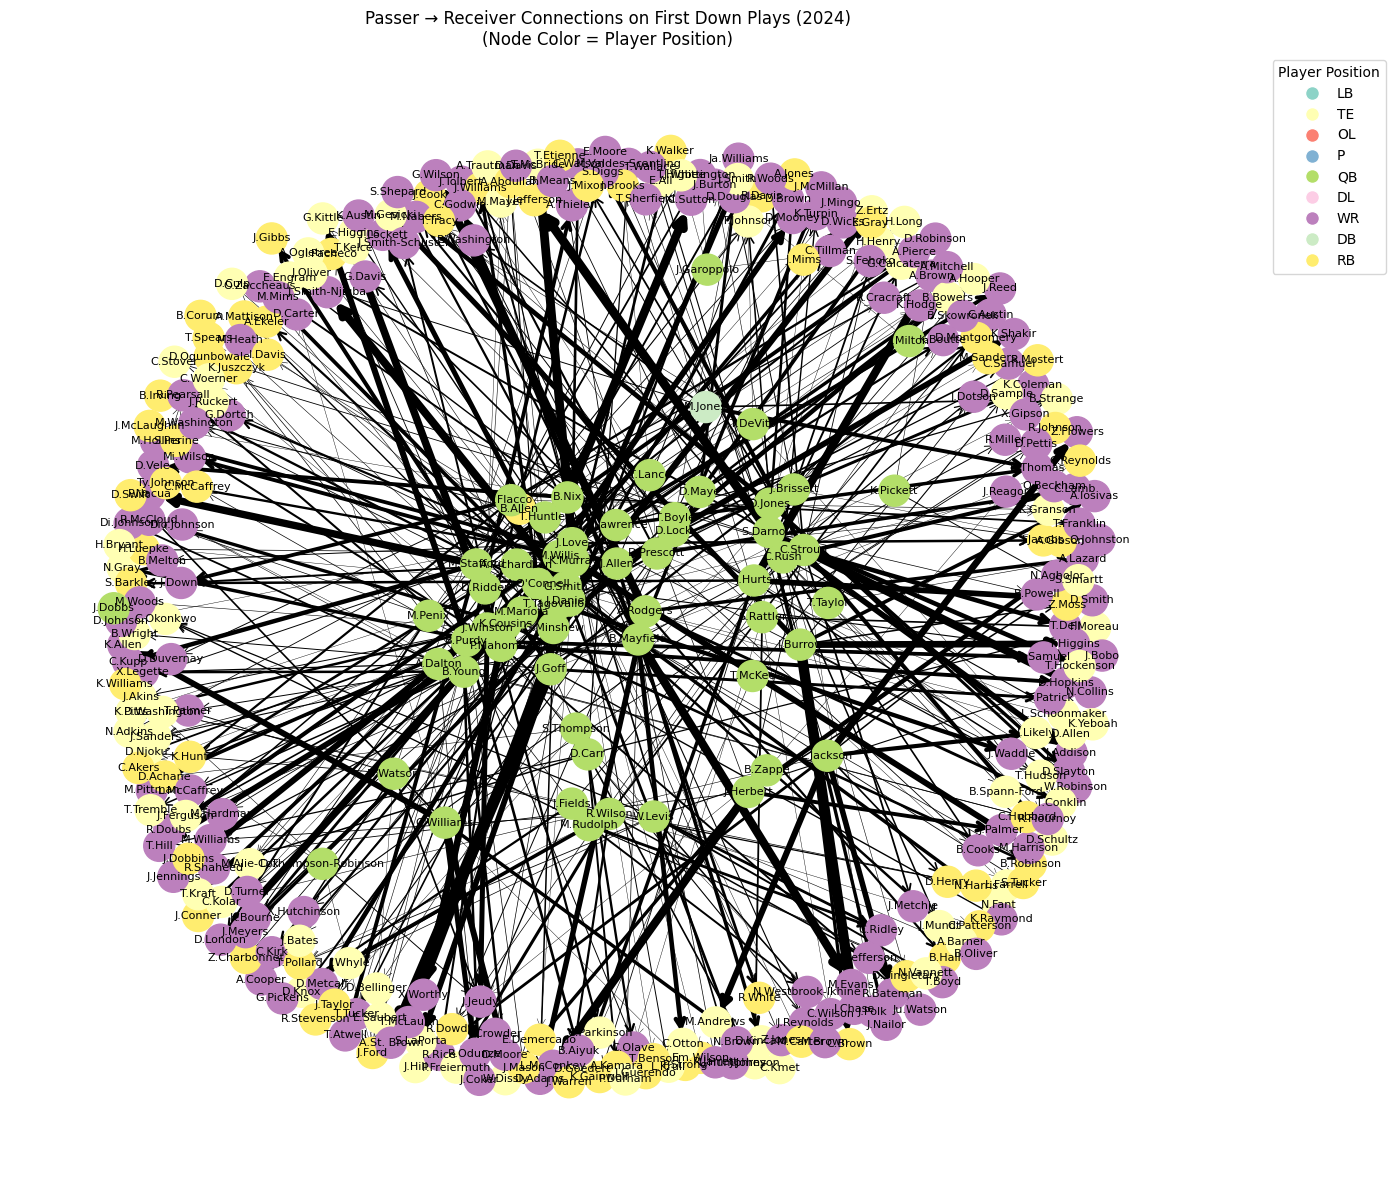

In [381]:
# Filter for plays resulting in a first down and where both passer and receiver are known
fd_pass_plays = df[
    (df['first_down'] == 1) &
    (df['passer_player_name'].notna()) &
    (df['receiver_player_name'].notna())
].copy()

fd_pass_plays["passer_position"] = fd_pass_plays['passer_player_id'].apply(get_player_position)
fd_pass_plays["receiver_position"] = fd_pass_plays['receiver_player_id'].apply(get_player_position)

# Create edge list: (passer, receiver)
edges = list(zip(fd_pass_plays['passer_player_name'], fd_pass_plays['receiver_player_name']))

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights (count how many times each passer → receiver pair occurs)
for edge in edges:
    if G.has_edge(*edge):
        G[edge[0]][edge[1]]['weight'] += 1
    else:
        G.add_edge(edge[0], edge[1], weight=1)

# Optionally, filter edges to show only those with weight > threshold (e.g., 2)
edges_to_draw = [(u, v) for u, v, w in G.edges(data='weight') if w > 2]

H = G.edge_subgraph(edges_to_draw).copy()

# Create a mapping of player names to positions
player_positions = {}

# Add passer positions
for _, row in fd_pass_plays[['passer_player_name', 'passer_position']].drop_duplicates().iterrows():
    player_positions[row['passer_player_name']] = row['passer_position']

# Add receiver positions
for _, row in fd_pass_plays[['receiver_player_name', 'receiver_position']].drop_duplicates().iterrows():
    player_positions[row['receiver_player_name']] = row['receiver_position']

# Get unique positions and create color mapping
unique_positions = list(set(player_positions.values()))
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_positions)))
position_color_map = dict(zip(unique_positions, colors))

# Map colors to nodes in the graph
node_colors = []
for node in H.nodes():
    if node in player_positions:
        node_colors.append(position_color_map[player_positions[node]])
    else:
        node_colors.append('gray')  # Default color for unknown positions

# Plotting
plt.figure(figsize=(14,12))

# Position nodes using spring layout (forces)
pos = nx.spring_layout(H, k=0.5, iterations=50)

# Draw nodes with position-based colors
nx.draw_networkx_nodes(H, pos, node_size=500, node_color=node_colors)

# Draw edges with widths proportional to weight (made thinner)
weights = [H[u][v]['weight'] for u,v in H.edges()]
nx.draw_networkx_edges(H, pos, width=[w*0.1 for w in weights], arrowstyle='->', arrowsize=15)

# Draw labels
nx.draw_networkx_labels(H, pos, font_size=8)

# Create legend for positions
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=position_color_map[pos], 
                             markersize=10, label=pos) 
                  for pos in unique_positions]
plt.legend(handles=legend_elements, title='Player Position', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Passer → Receiver Connections on First Down Plays (2024)\n(Node Color = Player Position)")
plt.axis('off')
plt.tight_layout()
plt.show()


This visualization shows that quarterbacks, largely clustered in the center pass to predominantly wide receivers and also running backs. While it's hard to read individual players, we can see a trend in passer-receiver relationships.

To find the most efficient first downs, we must consider both the passing and receiving players. The quarterback position is always going to be the passing player. However, we need to look at multiple positions for the potential best receiving player to create our most cost-efficient pair that achieves first downs.

So let's evaluate passing plays by pairing each receiver and passer to find the most cost-efficient combination.

In [447]:
# Filter for plays with a first down via pass, and valid passer + receiver names
first_down_passes = df[
    (df['first_down_pass'] == 1) & 
    df['passer_player_name'].notna() & 
    df['receiver_player_name'].notna() & 
    df['posteam'].notna()
].copy()

# Get full names for passer and receiver
first_down_passes['passer_player_name'] = first_down_passes['passer_player_id'].apply(get_player_name)
first_down_passes['receiver_player_name'] = first_down_passes['receiver_player_id'].apply(get_player_name)
first_down_passes['receiver_position'] = first_down_passes['receiver_player_id'].apply(get_player_position)

# Group by passer, receiver, and offensive team (posteam), count occurrences
pair_counts = (
    first_down_passes
    .groupby(['passer_player_name', 'passer_player_id', 'receiver_player_name', 'receiver_position', 'receiver_player_id', 'posteam'])
    .size()
    .reset_index(name='First_Down_Count')
    .sort_values(by='First_Down_Count', ascending=False)
)

In [ ]:
# Fuzzy match passer and receiver names to salary data
pair_salary_df = pair_counts.copy()

# Merge salaries for passer
pair_salary_df = pair_salary_df.merge(
    player_salary_df[['player_name_x', 'base_salary', 'player_id']],
    left_on='passer_player_id',
    right_on='player_id',
    how='left'
).rename(columns={'base_salary': 'passer_salary'}).drop(columns=['player_name_x'])

# Merge salaries for receiver
pair_salary_df = pair_salary_df.merge(
    player_salary_df[['player_name_x', 'base_salary', 'player_id']],
    left_on='receiver_player_id',
    right_on='player_id',
    how='left'
).rename(columns={'base_salary': 'receiver_salary'}).drop(columns=['player_name_x'])

# Fill missing salaries with 0
pair_salary_df['passer_salary'] = pair_salary_df['passer_salary'].fillna(0)
pair_salary_df['receiver_salary'] = pair_salary_df['receiver_salary'].fillna(0)

# Calculate total salary and salary per first down
pair_salary_df['total_salary'] = pair_salary_df['passer_salary'] + pair_salary_df['receiver_salary']
pair_salary_df['salary_per_first_down'] = pair_salary_df['total_salary'] / pair_salary_df['First_Down_Count']

pair_salary_df = pair_salary_df.sort_values(by='salary_per_first_down', ascending=True)

# Format dollar amounts
pair_salary_df['passer_salary'] = pair_salary_df['passer_salary'].apply(format_salary)
pair_salary_df['receiver_salary'] = pair_salary_df['receiver_salary'].apply(format_salary)
pair_salary_df['total_salary'] = pair_salary_df['total_salary'].apply(format_salary)
pair_salary_df['salary_per_first_down'] = pair_salary_df['salary_per_first_down'].apply(format_salary)

# Show relevant columns
display_df = pair_salary_df[['posteam', 'passer_player_name', 'receiver_player_name', 'receiver_position', 'First_Down_Count', 'total_salary', 'salary_per_first_down']]
display_df.head(20)

,posteam,passer_player_name,receiver_player_name,receiver_position,First_Down_Count,total_salary,salary_per_first_down
4,DEN,Bo Nix,Courtland Sutton,WR,61,"$1,920,000.00","$31,475.41"
9,PHI,Jalen Hurts,A.J. Brown,WR,58,"$2,250,000.00","$38,793.10"
5,TB,Baker Mayfield,Mike Evans,WR,60,"$2,335,000.00","$38,916.67"
35,CHI,Caleb Williams,Rome Odunze,WR,37,"$1,590,000.00","$42,972.97"
18,WAS,Jayden Daniels,Zach Ertz,TE,46,"$2,005,000.00","$43,586.96"
7,HOU,C.J. Stroud,Nico Collins,WR,58,"$2,531,000.00","$43,637.93"
21,SF,Brock Purdy,Jauan Jennings,WR,43,"$2,040,000.00","$47,441.86"
0,DET,Jared Goff,Amon-Ra St. Brown,WR,81,"$3,977,832.00","$49,109.04"
19,SF,Brock Purdy,George Kittle,TE,44,"$2,195,000.00","$49,886.36"
25,BUF,Josh Allen,Khalil Shakir,WR,42,"$2,110,000.00","$50,238.10"


In [446]:
df_plot = pair_salary_df.copy()
df_plot['salary_per_first_down_num'] = df_plot['salary_per_first_down'].replace('[\$,]', '', regex=True).astype(float)
df_plot['total_salary'] = df_plot['total_salary'].replace('[\$,]', '', regex=True).astype(float)

# Base chart
base = alt.Chart(df_plot).encode(
    x=alt.X('First_Down_Count:Q', title='First Down Count (Volume)'),
    y=alt.Y('total_salary:Q', title='Total Salary ($)', 
            axis=alt.Axis(format='$,.0f')),
    size=alt.Size('First_Down_Count:Q', scale=alt.Scale(type='pow', exponent=2, range=[30, 400])),
    color=alt.Color('salary_per_first_down_num:Q', scale=alt.Scale(scheme='viridis'),
                    title='Salary per First Down ($)'),
    tooltip=[
        alt.Tooltip('posteam:N', title='Team'),
        alt.Tooltip('passer_player_name:N', title='Quarterback'),
        alt.Tooltip('receiver_player_name:N', title='Receiver'),
        alt.Tooltip('First_Down_Count:Q', title='First Down Count'),
        alt.Tooltip('total_salary:Q', format='$,.0f', title='Total Salary'),
        alt.Tooltip('salary_per_first_down_num:Q', format='$,.0f', title='Salary per First Down')
    ]
)

# Scatter plot
points = base.mark_circle(opacity=0.7, stroke='white', strokeWidth=0.5)

# Combine
chart = (points).properties(
    width=700,
    height=500,
    title='Top Passer-Receiver Pairs by Total Salary vs. First Down Count\n(Size = Volume, Color = Cost per First Down)'
)

chart.show()

alt.Chart(...)

We found the most cost-efficient pair in Bo Nix and Courtland Sutton from the Denver Broncos. However, notable outliers include the Detroit Lion's Jared Goff and Amon-Ra St. Brown. The Lions pair have the highest first down count while still being very cost-efficient, well below the average cost per first down.

The average cost of a first down in the entire NFL is $153,019.86. The average cost of a wide receiver first down is $230,606. The most efficient pair in the league, belonging to the Broncos, averages $31,475.41 per first down. The notable outlier pair from the Lions averages $49,019 per first down.

## Conclusion

Teams need to invest in key players, namely a good quarterback and receiver pair. The receiver can be from a variety of positions. Wide receivers tend to be the most effective on average, excluding certain extraordinary tight-ends.

After finding that pair, teams should then prioritize running backs as they are the most cost-efficient position as a whole.
